Metadata loaded. Sample rows:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Image counts per folder: {}
Image counts from deeper search: {'HAM10000_images_part_1': 5000, 'HAM10000_images_part_2': 5015}
Class distribution: {'bkl': 1099, 'nv': 6705, 'df': 115, 'mel': 1113, 'vasc': 142, 'bcc': 514, 'akiec': 327}


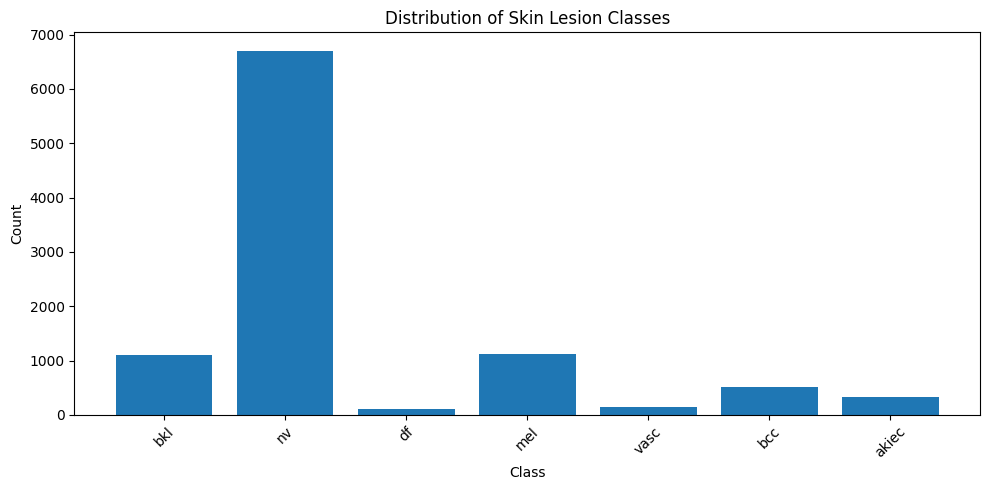

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'C:\\Users\\mcf\\PycharmProjects\\DeepLearnME\\data\\HAM10000_images_part_1'

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from pathlib import Path

# Project root directory
project_root = "C:\\Users\\mcf\\PycharmProjects\\DeepLearnME"
data_dir = os.path.join(project_root, "data")

# Find metadata CSV dynamically
metadata_path = None
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file == "HAM10000_metadata.csv":
            metadata_path = os.path.join(root, file)
            break
    if metadata_path:
        break

# Load metadata
df = None
if metadata_path and os.path.exists(metadata_path):
    df = pd.read_csv(metadata_path)
    print("Metadata loaded. Sample rows:")
    print(df.head())
else:
    print("Metadata CSV not found. Check data/ structure or dataset contents.")

# Count images in expected HAM10000 structure (e.g., ham10000_images_part_1)
image_counts = {}
expected_image_folders = ["ham10000_images_part_1", "ham10000_images_part_2"]  # Adjust based on actual names
for folder in expected_image_folders:
    folder_path = os.path.join(data_dir, folder)
    if os.path.exists(folder_path):
        image_counts[folder] = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
print("Image counts per folder:", image_counts)

# If no images found, search deeper in case of nesting
if not image_counts:
    for root, dirs, files in os.walk(data_dir):
        for dir_name in dirs:
            if "images" in dir_name.lower():
                folder_path = os.path.join(root, dir_name)
                image_counts[dir_name] = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print("Image counts from deeper search:", image_counts)

# Class distribution from metadata
if df is not None and 'dx' in df.columns:  # Check if df is defined and has 'dx' column
    class_dist = Counter(df['dx'])
    print("Class distribution:", dict(class_dist))

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_dist.keys(), class_dist.values())
    plt.title("Distribution of Skin Lesion Classes")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(project_root, "class_distribution.png"))
    plt.show()
else:
    print("No class distribution plotted due to missing metadata or 'dx' column.")

# Visualize a sample image
sample_folder = next((f for f in image_counts.keys()), None)
if sample_folder:
    sample_path = os.path.join(data_dir, sample_folder, os.listdir(os.path.join(data_dir, sample_folder))[0])
    if os.path.exists(sample_path):
        img = cv2.imread(sample_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(img_rgb)
        plt.title("Sample Skin Lesion Image")
        plt.axis('off')
        plt.savefig(os.path.join(project_root, "sample_image.png"))
        plt.show()
    else:
        print(f"Sample image not found at {sample_path}. Verify image files.")
else:
    print("No image folder found after search. Verify dataset structure in data/.")